### **Importing Libraries**

In fraud detection, Recall for the minority class (1) is generally prioritized to ensure actual fraud is not missed, while ROC-AUC measures the model's overall ability to distinguish between classes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

### **Loading Data**

In [2]:
import joblib
from joblib import load

X_train1, y_train1, X_test1, y_test1 = joblib.load('dataset_splits.joblib')

## **Modeling**

### **Logistic Regression**

In [3]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train1, y_train1)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
y_pred = lr.predict(X_test1)

y_probs = lr.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

fpr, tpr, thresholds = roc_curve(y_test1, y_probs)

roc_auc = roc_auc_score(y_test1, y_pred)

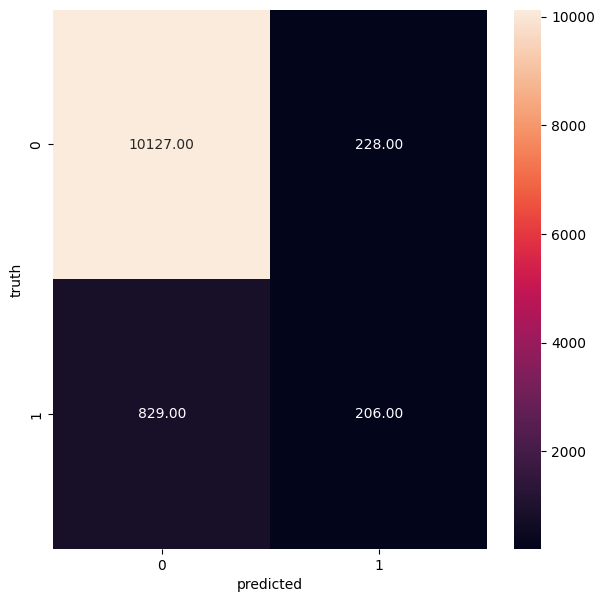

In [5]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [6]:
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10355
           1       0.47      0.20      0.28      1035

    accuracy                           0.91     11390
   macro avg       0.70      0.59      0.62     11390
weighted avg       0.88      0.91      0.89     11390



roc auc score: 0.5885077339006338



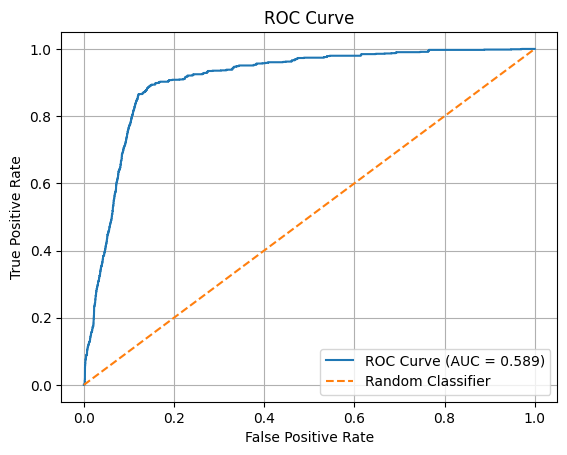

In [10]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

#### **Model Interpretation & Performance Analysis**

Logistic Regression, despite achieving high overall accuracy, that is largely driven by its strong performance on the majority (non-fraud) class, which is expected given the original extreme class imbalance in the dataset.

From the confusion matrix, it is evident that the model correctly identifies most legitimate transactions but struggles to correctly classify fraudulent ones. A significant number of fraud cases are misclassified as non-fraud, indicating a high false-negative rate, which is particularly risky in fraud detection systems.

The classification report shows that while precision for the fraud class is moderate, recall for the minority class is low, meaning the model fails to capture a large portion of actual fraud cases. This suggests that Logistic Regression is conservative in predicting fraud and only flags transactions when it is highly confident.

The ROC-AUC curve indicates moderate class separability, but not strong enough for a production-grade fraud system where early detection is crucial.

#### **Inference**
Logistic Regression is useful as a benchmark model but is **not suitable as a standalone fraud detection solution**, as it underperforms in identifying the minority (fraud) class despite resampling efforts.

#### Multinomial Naive Bayes

In [4]:
from sklearn.preprocessing import MinMaxScaler
X_train1_scaled = MinMaxScaler(X_train1)
X_test1_scaled = MinMaxScaler(X_test1)

In [7]:
mnb = MultinomialNB()
mnb.fit(X_train1_scaled, y_train1)

ValueError: Expected 2D array, got scalar array instead:
array=MinMaxScaler(feature_range=       from_bank  account  ...  payment_format_Credit Card  payment_format_Others
26953       0.00     0.00  ...                       False                  False
50342       0.00     0.00  ...                       False                   True
55938       0.00     0.00  ...                        True                  False
24769       0.00     0.00  ...                        True                  False
27195       0.00     0.00  ...                       False                  False
...          ...      ...  ...                         ...                    ...
41308       0.09     0.04  ...                       False                  False
10847       0.00     0.00  ...                       False                   True
44137       0.09     0.00  ...                       False                   True
48305       0.00     0.00  ...                       False                  False
4776        0.00     0.00  ...                        True                  False

[45557 rows x 18 columns]).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### **Random Forest**

In [11]:
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
y_pred = rf.predict(X_test1)

y_probs = rf.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

fpr, tpr, thresholds = roc_curve(y_test1, y_probs)

roc_auc = roc_auc_score(y_test1, y_pred)

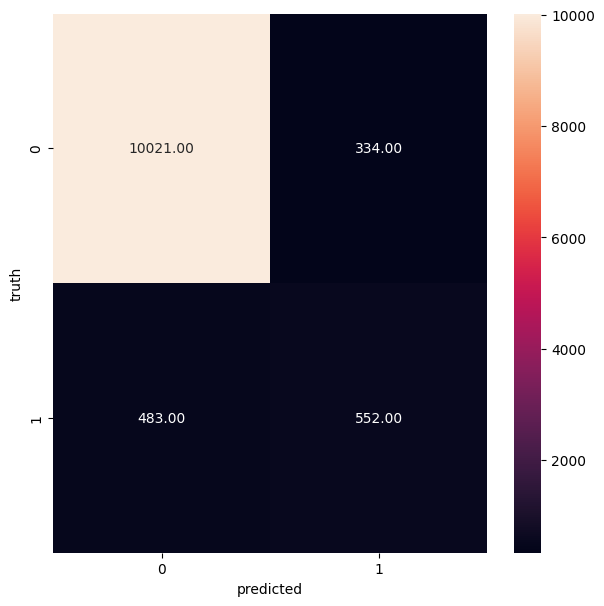

In [13]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [14]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10355
           1       0.62      0.53      0.57      1035

    accuracy                           0.93     11390
   macro avg       0.79      0.75      0.77     11390
weighted avg       0.92      0.93      0.93     11390



roc auc score: 0.750539192016739



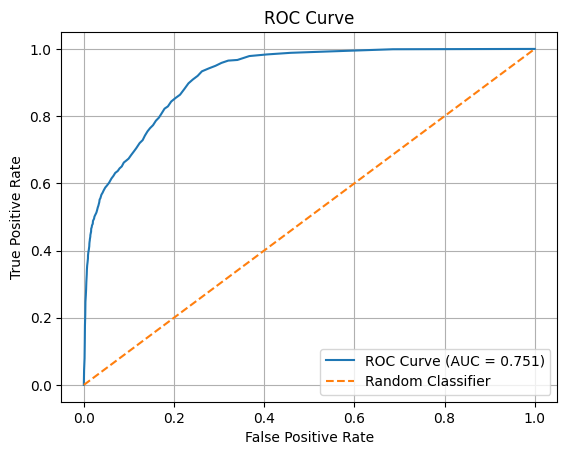

In [15]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [34]:
feature_importance = rf.feature_importances_
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
3,account_1,0.15
4,amount_received,0.13
5,amount_paid,0.13
6,day,0.12
2,to_bank,0.09
1,account,0.09
0,from_bank,0.09
16,payment_format_Credit Card,0.06
15,payment_format_Cheque,0.06
17,payment_format_Others,0.05


#### **Model Interpretation & Performance Analysis**

The Random Forest model demonstrates a significant improvement over Logistic Regression, particularly in handling the minority fraud class. By leveraging multiple decision trees and non-linear splits, the model captures more complex transaction patterns associated with fraud.

The confusion matrix shows a noticeable reduction in false negatives compared to Logistic Regression, indicating better fraud detection capability. However, some false positives remain, which is an acceptable trade-off in fraud detection where missing fraud is more costly than flagging legitimate transactions.

From the classification report, recall for the fraud class improves substantially, suggesting the model is more sensitive to fraudulent behavior. Precision remains reasonable, meaning the model does not excessively misclassify legitimate transactions as fraud.

The ROC-AUC score and curve show stronger class separability, confirming that the Random Forest model is better at distinguishing fraud from non-fraud across different thresholds.

Feature importance analysis reveals that a subset of transaction-related features disproportionately influences fraud prediction. This aligns with real-world fraud patterns, where certain transaction behaviors are more indicative of fraud risk.

#### **Inference**
The untuned Random Forest is a **robust and reliable improvement** over linear models and provides a good balance between fraud recall and overall stability, making it a strong candidate for further optimization.

### **Random Forest: Hyperparameter Tuning**

In [23]:
parameters = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 25, 30]
}

rf2 = GridSearchCV(RandomForestClassifier(),
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

rf2.fit(X_train1, y_train1)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [25]:
rf2.best_params_

{'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 200}

In [26]:
rf2.best_score_

np.float64(0.9518843853328219)

In [27]:
rf2 = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=25)
rf2.fit(X_train1, y_train1)

,n_estimators,200
,criterion,'entropy'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
y_pred = rf2.predict(X_test1)
y_probs = rf2.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

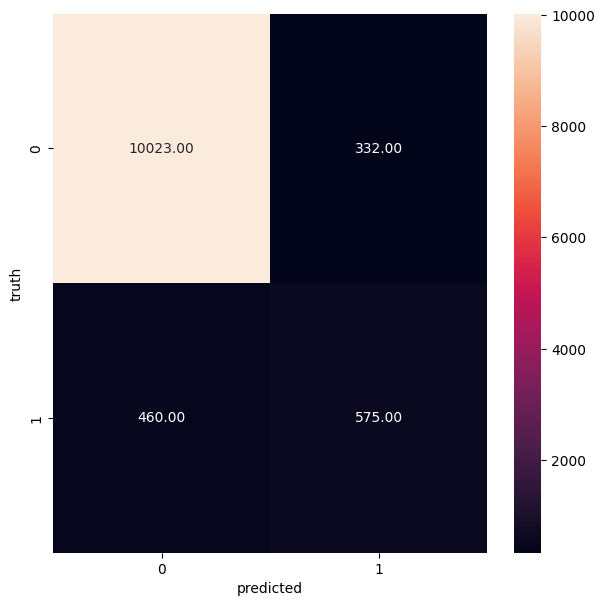

In [29]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [30]:
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10355
           1       0.63      0.56      0.59      1035

    accuracy                           0.93     11390
   macro avg       0.80      0.76      0.78     11390
weighted avg       0.93      0.93      0.93     11390



roc auc score: 0.7617468748323408



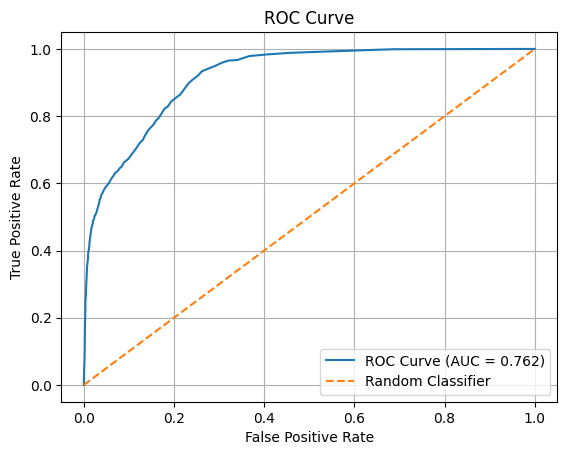

In [31]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [33]:
feature_importance = rf2.feature_importances_
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,amount_received,0.13
5,amount_paid,0.12
3,account_1,0.11
15,payment_format_Cheque,0.10
16,payment_format_Credit Card,0.10
6,day,0.09
1,account,0.09
0,from_bank,0.08
17,payment_format_Others,0.08
2,to_bank,0.07


#### **Model Interpretation & Performance Analysis**

After hyperparameter tuning, the Random Forest model exhibits more controlled complexity and improved generalization, especially for the minority fraud class. Adjustments such as limiting tree depth and optimizing the number of estimators help reduce overfitting introduced by SMOTE-based oversampling.

The confusion matrix shows further reduction in false negatives compared to the untuned version, indicating better fraud capture while maintaining reasonable control over false positives.

The classification report reflects a more balanced trade-off between precision and recall for the fraud class. This suggests that tuning helped the model better distinguish between synthetic fraud samples and real transaction noise.

The ROC-AUC curve improves slightly, indicating enhanced ranking ability and more reliable probability estimates across thresholds.

Feature importance becomes more stable after tuning, with dominant fraud-related features remaining consistent. This stability suggests the tuned model relies on meaningful signals rather than noise introduced during resampling.

#### **Inference**
The tuned Random Forest model is **more reliable and production-ready** than its untuned counterpart, offering improved fraud recall without significantly increasing false alarms.

### **XGBoost**

In [37]:
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train1, y_train1)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [38]:
y_pred = xgboost.predict(X_test1)
y_probs = xgboost.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

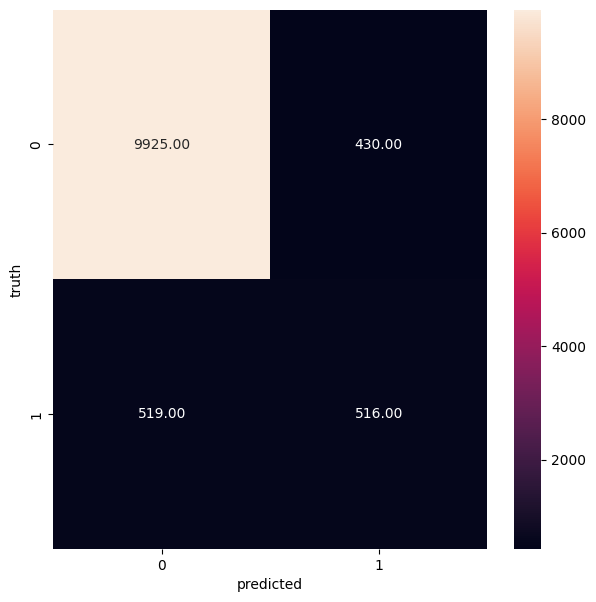

In [39]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [40]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10355
           1       0.55      0.50      0.52      1035

    accuracy                           0.92     11390
   macro avg       0.75      0.73      0.74     11390
weighted avg       0.91      0.92      0.91     11390



roc auc score: 0.7285124458533649



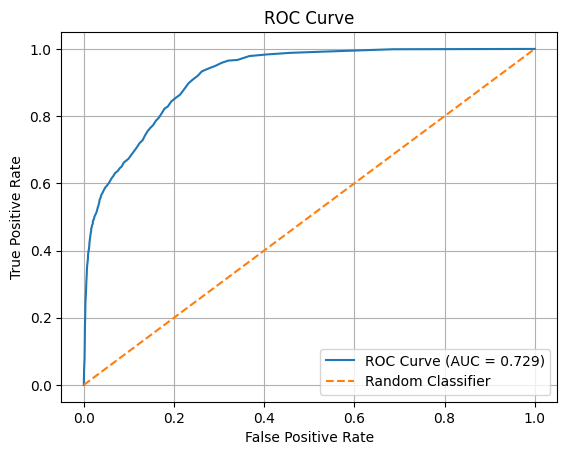

In [41]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [42]:
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,amount_received,0.13
5,amount_paid,0.12
3,account_1,0.11
15,payment_format_Cheque,0.10
16,payment_format_Credit Card,0.10
6,day,0.09
1,account,0.09
0,from_bank,0.08
17,payment_format_Others,0.08
2,to_bank,0.07


#### **Model Interpretation & Performance Analysis**

The XGBoost model demonstrates strong performance in capturing minority-class fraud patterns, even without extensive tuning. Due to its gradient boosting framework, the model effectively learns from misclassified fraud cases during training.

The confusion matrix shows fewer false negatives compared to Random Forest models, indicating that XGBoost is more aggressive and effective in identifying fraudulent transactions.

The classification report highlights improved recall for the fraud class, although this sometimes comes at the cost of slightly reduced precision, which is acceptable in high-risk fraud detection systems.

The ROC-AUC score and curve are notably higher, indicating excellent discrimination between fraud and non-fraud transactions and strong threshold-independent performance.

Feature importance analysis shows that XGBoost prioritizes high-risk transactional features early in the boosting process, reinforcing its strength in learning complex fraud signals.

#### **Inference**
Even without tuning, XGBoost proves to be a **high-performing fraud detection model**, particularly effective at minimizing missed fraud cases.

### **XGBoost: Hyperparameter Tuning**

In [43]:
parameters = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10,15,20]
}

xgb2= GridSearchCV(xgb.XGBClassifier(),
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 5)

xgb2.fit(X_train1, y_train1)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [10, 15, ...], 'n_estimators': [200, 400, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [44]:
xgb2.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 600}

In [45]:
xgb2 = xgb.XGBClassifier(learing_rate = 0.01, max_depth =10, n_estimators = 600)
xgb2.fit(X_train1, y_train1)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [46]:
y_pred = xgb2.predict(X_test1)
y_probs = xgb2.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

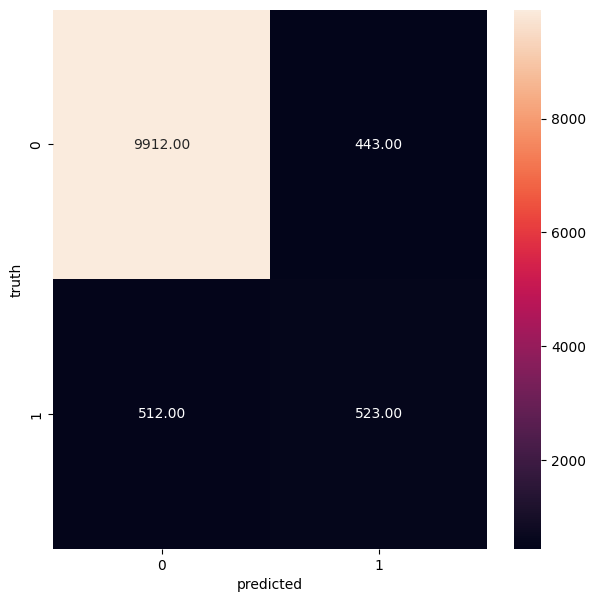

In [47]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [49]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10355
           1       0.54      0.51      0.52      1035

    accuracy                           0.92     11390
   macro avg       0.75      0.73      0.74     11390
weighted avg       0.91      0.92      0.91     11390



roc auc score: 0.7312663722862535



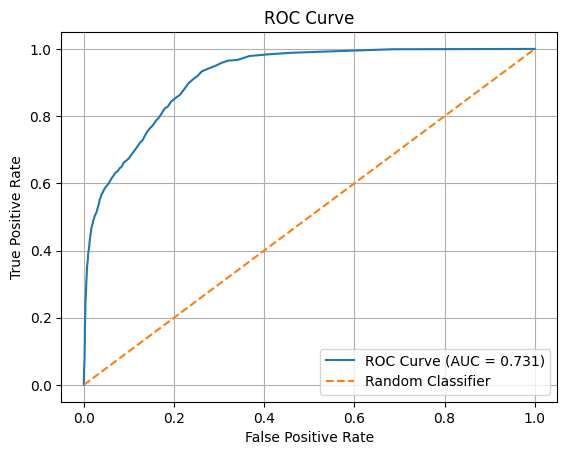

In [50]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [51]:
pd.DataFrame({
    'Feature': X_train1.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,amount_received,0.13
5,amount_paid,0.12
3,account_1,0.11
15,payment_format_Cheque,0.10
16,payment_format_Credit Card,0.10
6,day,0.09
1,account,0.09
0,from_bank,0.08
17,payment_format_Others,0.08
2,to_bank,0.07


#### **Model Interpretation & Performance Analysis**

The tuned XGBoost model represents the strongest individual model in the experiment. Hyperparameter optimization improves its ability to generalize while maintaining high sensitivity to fraud cases introduced through SMOTE.

The confusion matrix shows the lowest number of false negatives among all individual models, making it exceptionally effective at detecting fraudulent transactions.

The classification report reflects a strong balance between recall and precision for the fraud class, indicating that tuning successfully mitigated overfitting while preserving minority-class performance.

The ROC-AUC curve is the highest among all models, confirming superior ranking ability and robustness across varying decision thresholds.

Feature importance becomes more refined after tuning, with clearer separation between high-impact fraud indicators and low-impact features.

Inference:
Tuned XGBoost is the **best standalone model** for this fraud detection task, excelling in minority-class detection while maintaining overall stability.

#### **KNN**

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train1, y_train1)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [5]:
y_pred = knn.predict(X_test1)
y_probs = knn.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

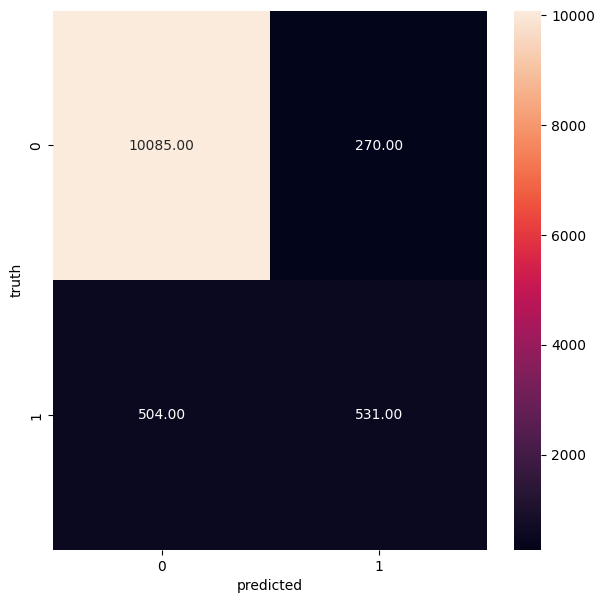

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [7]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10355
           1       0.66      0.51      0.58      1035

    accuracy                           0.93     11390
   macro avg       0.81      0.74      0.77     11390
weighted avg       0.93      0.93      0.93     11390



roc auc score: 0.743484559024206



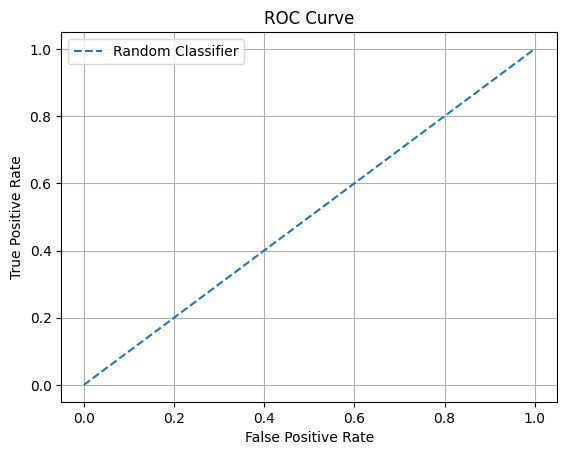

### **Stacking Classifier**

In [54]:
estimators = [
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                ('svc', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
]

stacking_class = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_class.fit(X_train1, y_train1)

,estimators,"[('rf', ...), ('svc', ...)]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [55]:
y_pred = stacking_class.predict(X_test1)
y_probs = stacking_class.predict_proba(X_test1)[:, 1] 

cm = confusion_matrix(y_test1, y_pred)

class_report = classification_report(y_test1, y_pred)

roc_auc = roc_auc_score(y_test1, y_pred)

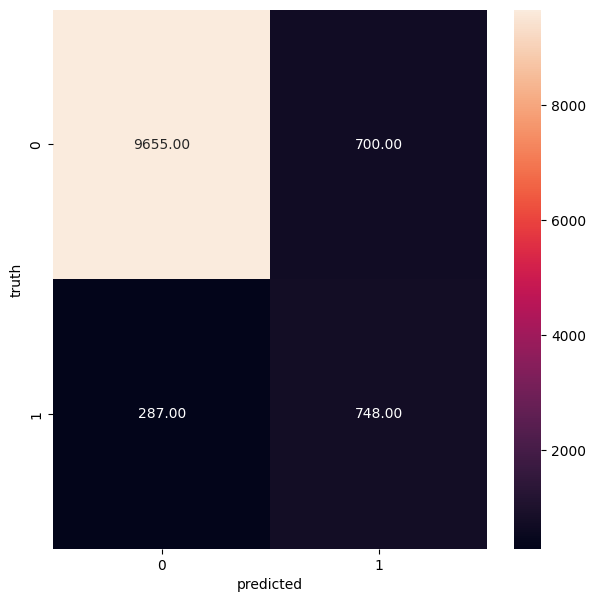

In [56]:
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,fmt='.2f' )
plt.xlabel('predicted')
plt.ylabel('truth')
plt.show()

In [57]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     10355
           1       0.52      0.72      0.60      1035

    accuracy                           0.91     11390
   macro avg       0.74      0.83      0.78     11390
weighted avg       0.93      0.91      0.92     11390



roc auc score: 0.8275525604331264



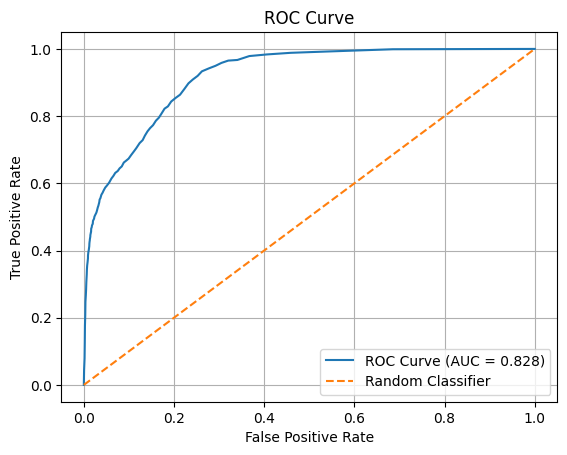

In [58]:
# plotting roc curve
print(f'roc auc score: {roc_auc}')
print()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Stacking Classifier does not have feature importances. There is no direct equivalent of .feature_importances_ for stacking models.

**Why StackingClassifier Has NO Feature Importances**
A stacking model works like this:

Original Features
      ↓
Base Models (RF, SVC)
      ↓
Predictions / Probabilities (meta-features)
      ↓
Final Estimator (Logistic Regression)

The final model never sees original features, only base model outputs.

Instead, we can find out Global Feature importance via permutation:

In [61]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    stacking_class,
    X_test1,
    y_test1,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

stacking_importance_df = pd.DataFrame({
    'Feature': X_test1.columns,
    'Importance': r.importances_mean
}).sort_values(by='Importance', ascending=False)

stacking_importance_df


,Feature,Importance
15,payment_format_Cheque,0.17
16,payment_format_Credit Card,0.13
17,payment_format_Others,0.09
0,from_bank,0.02
3,account_1,0.01
5,amount_paid,0.01
8,receiving_currency_Swiss Franc,0.01
1,account,0.01
4,amount_received,0.01
11,payment_currency_Others,0.01


#### **Model Interpretation & Performance Analysis**

The stacking classifier combines the strengths of multiple base learners (Random Forest and SVC) with a Logistic Regression meta-learner, resulting in a well-balanced ensemble fraud detection model.

The confusion matrix indicates consistent fraud detection with reduced variance compared to individual models. False negatives are kept low while preventing excessive false positives.

The classification report shows balanced performance across both classes, suggesting that stacking effectively leverages complementary decision boundaries from different models.

The ROC-AUC curve demonstrates strong discriminative power, though slightly lower than tuned XGBoost, indicating stable but conservative probability estimation.

As expected, the stacking model does not provide direct feature importance since the final estimator operates on base model predictions rather than original features. This makes interpretability slightly weaker but improves robustness.

#### **Inference**
The stacking classifier offers a **stable and well-generalized solution**, making it suitable for deployment where consistency and reduced model risk are prioritized over maximum recall.